In [2]:
import os
from pathlib import Path

import numpy as np
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import minimize
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)


/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [54]:
class Sigma:
    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        sigma0 = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        ginv = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        gf = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma0[e] = energy - self.H_eff
            gf[e] = g[..., e]
            # ginv[e] = np.linalg.inv(g[..., e])
            ginv[e] = np.linalg.pinv(g[..., e], rcond=1e-4)
            sigma[e] = energy - self.H_eff - ginv[e]
        return gf, ginv, sigma0, sigma

def plot_callback_factory(energies, H_eff, V, beta, eta, output_folder):
    fig_dir = os.path.join(output_folder, "figures")
    os.makedirs(fig_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.ion()

    def callback(dc_diag):
        DC = np.diag(dc_diag)
        neig = np.ones((H_eff.shape[0] + 1) ** 2, int) * 4
        espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
        screen_espace(espace, egs, beta)
        gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
        sigma = Sigma(gf, H_eff, eta=eta)
        sig = sigma.retarded(energies)

        trace_real = np.trace(sig.real, axis1=1, axis2=2)
        trace_imag = np.trace(sig.imag, axis1=1, axis2=2)

        ax.clear()
        ax.plot(energies, trace_real, label="Tr[Re Σ(ω)]", linestyle='-')
        ax.plot(energies, trace_imag, label="Tr[Im Σ(ω)]", linestyle='--')
        ax.set_xlabel("Energy (eV)")
        ax.set_ylabel("Tr Σ(ω)")
        ax.set_title(f"Self-energy Trace – Iteration {callback.counter}")
        ax.legend(loc="upper right", fontsize="medium")
        ax.grid(True)

        fig_path = os.path.join(fig_dir, f"sigma_trace_iter_{callback.counter:03d}.png")
        fig.savefig(fig_path, dpi=150)
        plt.pause(0.1)
        callback.counter += 1

    callback.counter = 0
    return callback


In [10]:
input_folder = "./output/lowdin"
H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
H_bare = np.load(f"{input_folder}/bare_hamiltonian.npy")
H_bare = H_bare.real
occupancy_goal = np.load(f"{input_folder}/beta_1000/occupancies.npy")
output_folder = "./output/lowdin/beta_1000/ed"
os.makedirs(output_folder, exist_ok=True)
nimp = H_eff.shape[0]
de = 0.01
energies = np.arange(-6.5, 6.5 + de / 2.0, de).round(7)
eta = 1e-3
beta = 1e3
V = np.loadtxt(f"{input_folder}/U_matrix.txt")
DC0 = np.diag(V.diagonal()*(occupancy_goal-0.5))
neig = np.ones((nimp+1)*(nimp+1),int) * 6

In [5]:
espace0, egs0 = build_espace(H_bare, np.zeros_like(V), neig_sector=neig)
print("espace0", espace0)
print("egs0", egs0)
screen_espace(espace0, egs0, beta)
print("after screen espace0", espace0)
print("after screen egs0", egs0)

espace0 {(0, 0): Sector(states=States(up=array([0], dtype=uint32), dw=array([0], dtype=uint32)), d=1, eigvals=array([0.]), eigvecs=array([[1.]])), (0, 1): Sector(states=States(up=array([0], dtype=uint32), dw=array([ 1,  2,  4,  8, 16, 32, 64], dtype=uint32)), d=7, eigvals=array([-5.75613586, -5.63727808, -3.87499031, -2.26078513,  0.22870088,
        3.17681967]), eigvecs=array([[ 0.27799862,  0.80608628, -0.34309128, -0.30865997, -0.20571193,
         0.12189766],
       [-0.16544558, -0.4165399 , -0.19259646, -0.43945696, -0.53113712,
         0.4679057 ],
       [ 0.12831679,  0.21114082,  0.49550466,  0.44577825, -0.06745106,
         0.51587561],
       [ 0.14382762,  0.06005999,  0.56921283, -0.10162284, -0.55185264,
        -0.06197745],
       [ 0.26243624, -0.05401612,  0.41880935, -0.52866344,  0.10516732,
        -0.44583555],
       [ 0.47433656, -0.17553738,  0.08053718, -0.31992841,  0.52117146,
         0.51262174],
       [-0.75121568,  0.30789716,  0.30623416, -0.34745

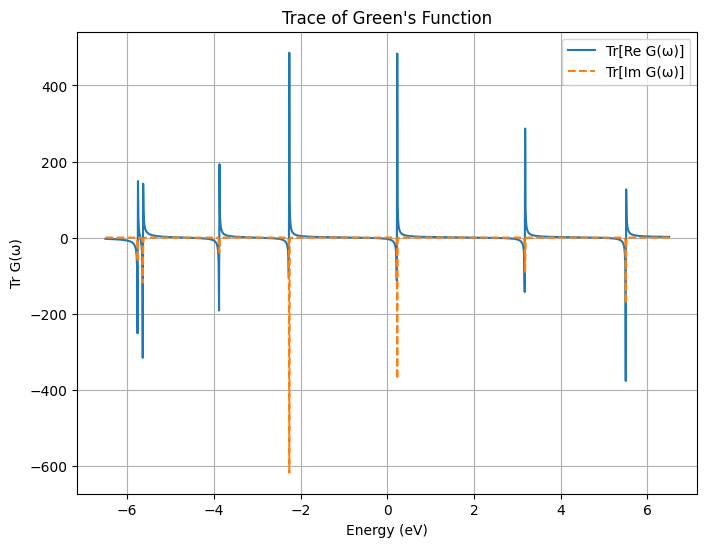

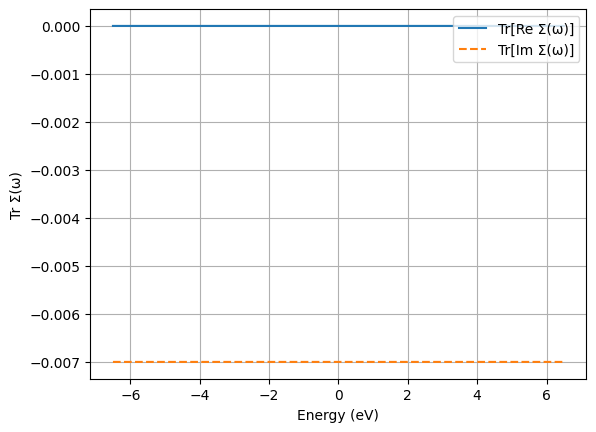

In [ ]:
espace0, egs0 = build_espace(H_bare, np.zeros_like(V), neig_sector=neig)
screen_espace(espace0, egs0, beta)
gf0 = build_gf2_lanczos(H_bare, np.zeros_like(V), espace0, beta, egs0)
sigma_class = Sigma(gf0, H_bare, eta=eta)
sig0 = sigma_class.retarded(energies)
g0 = gf0(energies, eta)
trace_real0 = np.trace(g0.real, axis1=0, axis2=1)
trace_imag0 = np.trace(g0.imag, axis1=0, axis2=1)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(energies, trace_real0, label="Tr[Re G(ω)]", linestyle='-')
plt.plot(energies, trace_imag0, label="Tr[Im G(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr G(ω)")
plt.title("Trace of Green's Function")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()
trace_real_term3 = np.trace(sig0.real, axis1=1, axis2=2)
trace_imag_term3 = np.trace(sig0.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term3, label="Tr[Re Σ(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term3, label="Tr[Im Σ(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ(ω)")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

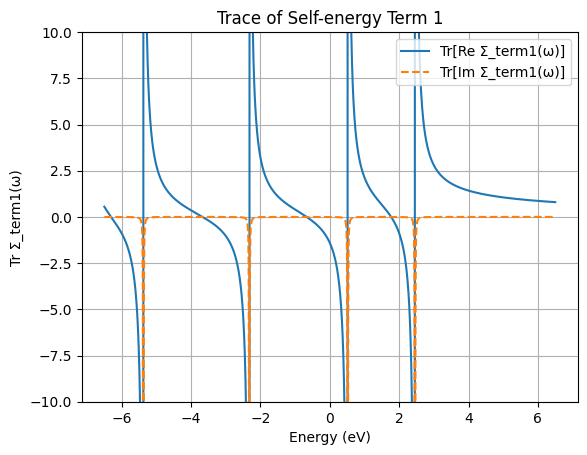

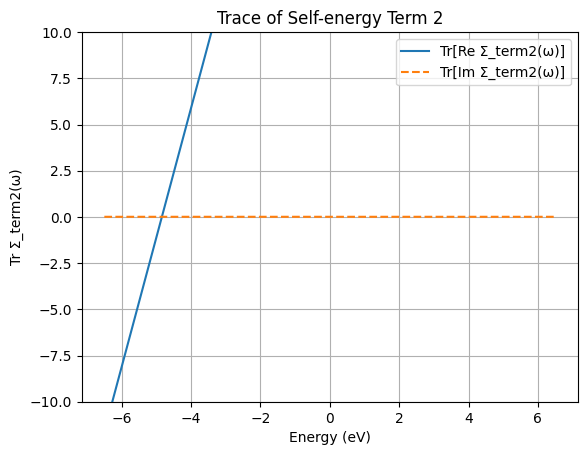

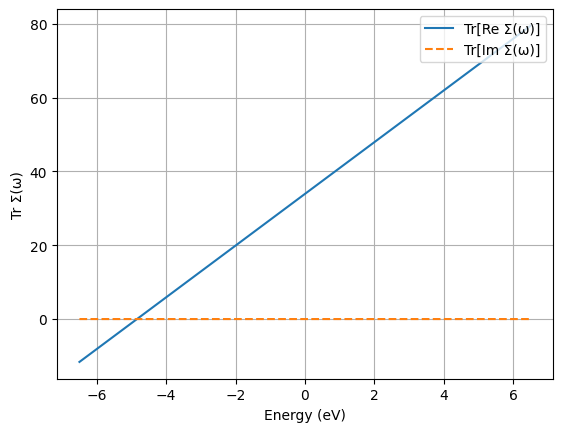

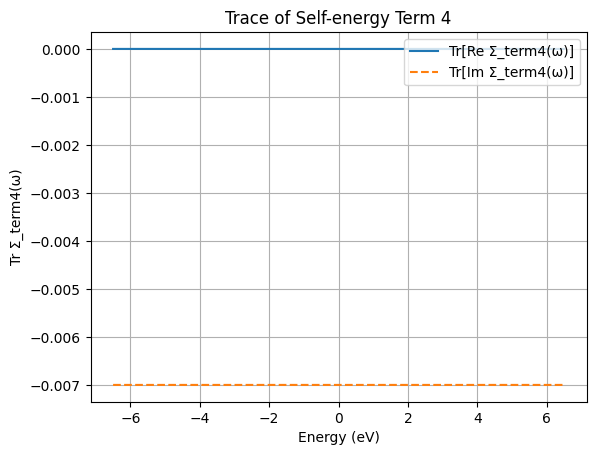

In [47]:
espace0, egs0 = build_espace(H_eff-DC0, np.zeros_like(V), neig_sector=neig)
screen_espace(espace0, egs0, beta)
gf0 = build_gf2_lanczos(H_eff-DC0, np.zeros_like(V), espace0, beta, egs0)
sigma_class = Sigma(gf0, H_eff-DC0, eta=eta)
gf, ginv, sigma0, sigma = sigma_class.retarded(energies)

trace_real_term1 = np.trace(gf.real, axis1=1, axis2=2)
trace_imag_term1 = np.trace(gf.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term1, label="Tr[Re Σ_term1(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term1, label="Tr[Im Σ_term1(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term1(ω)")
plt.ylim(-10,10)
plt.title("Trace of Self-energy Term 1")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term2 = np.trace(ginv.real, axis1=1, axis2=2)
trace_imag_term2 = np.trace(ginv.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term2, label="Tr[Re Σ_term2(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term2, label="Tr[Im Σ_term2(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term2(ω)")
plt.ylim(-10,10)
plt.title("Trace of Self-energy Term 2")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term3 = np.trace(sigma0.real, axis1=1, axis2=2)
trace_imag_term3 = np.trace(sigma0.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term3, label="Tr[Re Σ(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term3, label="Tr[Im Σ(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ(ω)")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term4 = np.trace(sigma.real, axis1=1, axis2=2)
trace_imag_term4 = np.trace(sigma.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term4, label="Tr[Re Σ_term4(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term4, label="Tr[Im Σ_term4(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term4(ω)")
plt.title("Trace of Self-energy Term 4")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

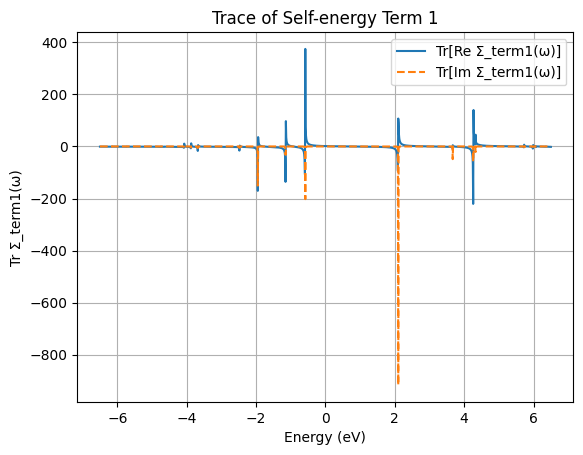

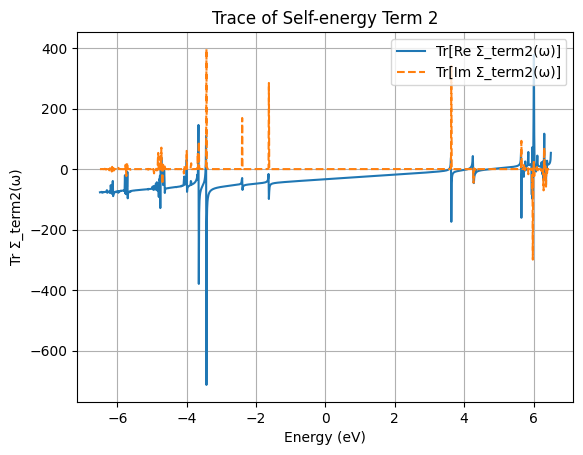

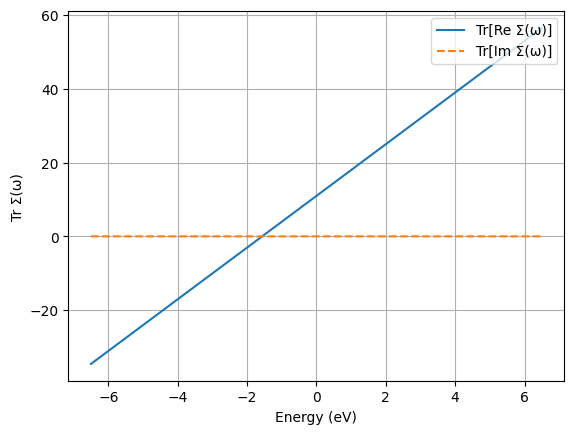

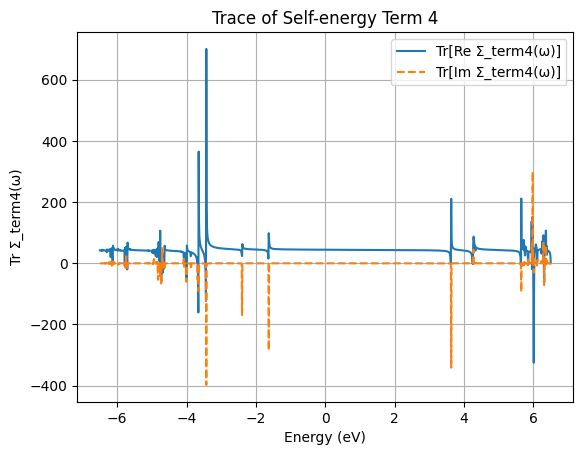

In [55]:
espace0, egs0 = build_espace(H_eff, V, neig_sector=neig)
screen_espace(espace0, egs0, beta)
gf0 = build_gf2_lanczos(H_eff, V, espace0, beta, egs0)
sigma_class = Sigma(gf0, H_eff, eta=eta)
gf, ginv, sigma0, sigma = sigma_class.retarded(energies)

trace_real_term1 = np.trace(gf.real, axis1=1, axis2=2)
trace_imag_term1 = np.trace(gf.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term1, label="Tr[Re Σ_term1(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term1, label="Tr[Im Σ_term1(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term1(ω)")
plt.title("Trace of Self-energy Term 1")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term2 = np.trace(ginv.real, axis1=1, axis2=2)
trace_imag_term2 = np.trace(ginv.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term2, label="Tr[Re Σ_term2(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term2, label="Tr[Im Σ_term2(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term2(ω)")
plt.title("Trace of Self-energy Term 2")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term3 = np.trace(sigma0.real, axis1=1, axis2=2)
trace_imag_term3 = np.trace(sigma0.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term3, label="Tr[Re Σ(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term3, label="Tr[Im Σ(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ(ω)")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term4 = np.trace(sigma.real, axis1=1, axis2=2)
trace_imag_term4 = np.trace(sigma.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term4, label="Tr[Re Σ_term4(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term4, label="Tr[Im Σ_term4(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term4(ω)")
plt.title("Trace of Self-energy Term 4")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

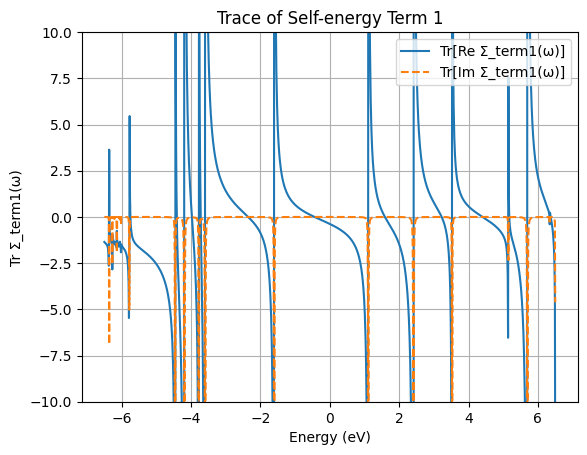

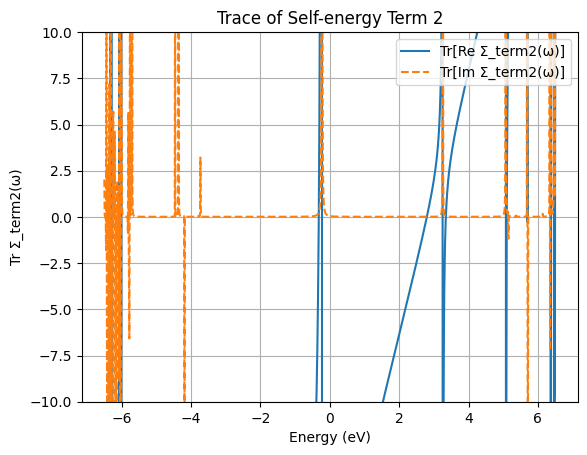

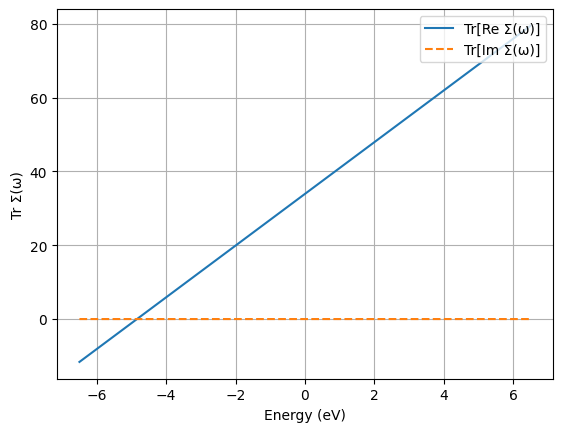

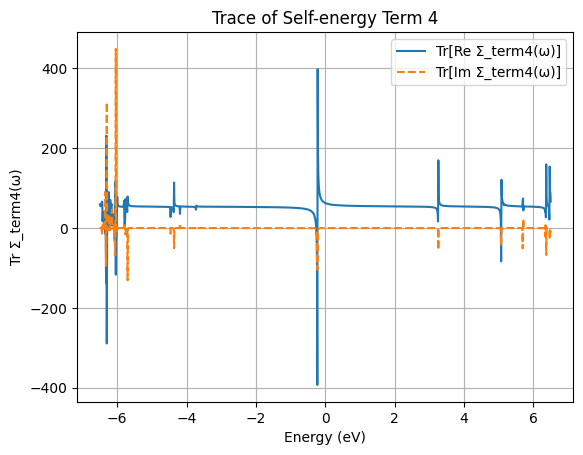

In [ ]:
espace0, egs0 = build_espace(H_eff-DC0, V, neig_sector=neig)
screen_espace(espace0, egs0, beta)
gf0 = build_gf2_lanczos(H_eff-DC0, V, espace0, beta, egs0)
sigma_class = Sigma(gf0, H_eff-DC0, eta=eta)
gf, ginv, sigma0, sigma = sigma_class.retarded(energies)

trace_real_term1 = np.trace(gf.real, axis1=1, axis2=2)
trace_imag_term1 = np.trace(gf.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term1, label="Tr[Re Σ_term1(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term1, label="Tr[Im Σ_term1(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term1(ω)")
plt.ylim(-10,10)
plt.title("Trace of Self-energy Term 1")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term2 = np.trace(ginv.real, axis1=1, axis2=2)
trace_imag_term2 = np.trace(ginv.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term2, label="Tr[Re Σ_term2(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term2, label="Tr[Im Σ_term2(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term2(ω)")
plt.ylim(-10,10)
plt.title("Trace of Self-energy Term 2")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term3 = np.trace(sigma0.real, axis1=1, axis2=2)
trace_imag_term3 = np.trace(sigma0.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term3, label="Tr[Re Σ(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term3, label="Tr[Im Σ(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ(ω)")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

trace_real_term4 = np.trace(sigma.real, axis1=1, axis2=2)
trace_imag_term4 = np.trace(sigma.imag, axis1=1, axis2=2)

plt.plot(energies, trace_real_term4, label="Tr[Re Σ_term4(ω)]", linestyle='-')
plt.plot(energies, trace_imag_term4, label="Tr[Im Σ_term4(ω)]", linestyle='--')
plt.xlabel("Energy (eV)")
plt.ylabel("Tr Σ_term4(ω)")
plt.title("Trace of Self-energy Term 4")
plt.legend(loc="upper right", fontsize="medium")
plt.grid(True)
plt.show()

In [ ]:
high_energy_mask = np.abs(energies) > 2.99

def F(double_counting_diag, high_energy_mask=np.abs(energies) > 10):

    DC = np.diag(double_counting_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma(gf, H_eff, eta=eta)
    sig = sigma.retarded(energies)
    sig_real_diag = sig.real.diagonal(axis1=1, axis2=2)
    residue = sig_real_diag[high_energy_mask, :]
    cost = np.linalg.norm(residue) / residue.shape[1]

    # sig_real = sig.real[high_energy_mask, :, :]  #
    # traces = np.trace(sig_real, axis1=1, axis2=2)
    # cost = np.sum(np.abs(traces))

    print(f"[F] Cost: {cost:.6f}, DC_diag: {double_counting_diag}")
    return cost

[F] Cost: 9.712028, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 10.469184, DC_diag: [5.96515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]


KeyboardInterrupt: 

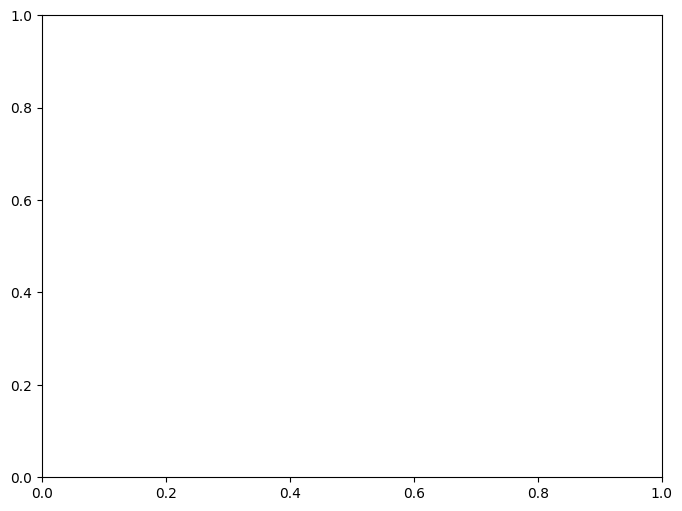

In [28]:
callback = plot_callback_factory(
    energies=energies,
    H_eff=H_eff,
    V=V,
    beta=beta,
    eta=eta,
    output_folder=output_folder,
)

res = minimize(
    lambda x: F(x, high_energy_mask),
    DC0.diagonal(),
    method="BFGS",
    callback=callback,
    options={"disp": True, "eps": 5e-1},
)


In [21]:
high_energy_mask = np.abs(energies) > 10
res = minimize(lambda x: F(x, high_energy_mask), DC0.diagonal(),
               method='L-BFGS-B', options={'disp': True, 'eps': 5e-1})


[F] Cost: 124.849064, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 71.824508, DC_diag: [5.96515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 84.792263, DC_diag: [5.46515887 2.47886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 86.826415, DC_diag: [5.46515887 1.97886514 3.02035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 107.184463, DC_diag: [5.46515887 1.97886514 2.52035611 2.72202704 2.7152016  2.12250731
 5.90703705]
[F] Cost: 74.088122, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 3.2152016  2.12250731
 5.90703705]
[F] Cost: 91.657429, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.62250731
 5.90703705]
[F] Cost: 230.289625, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 6.40703705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At

 This problem is unconstrained.


[F] Cost: 75.878397, DC_diag: [5.83132488 2.25548111 2.78292505 2.34401158 3.06573601 2.35171524
 5.17890744]


KeyboardInterrupt: 

In [ ]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

In [ ]:
DC_optimized = np.diag(res.x)
np.save(f"{output_folder}/DC_optimized.npy", DC_optimized)

espace, egs = build_espace(H_eff - DC_optimized, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC_optimized, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0, axis2=1)


plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U matrix optimized")
plt.legend()
plt.yscale('log')
plt.show()


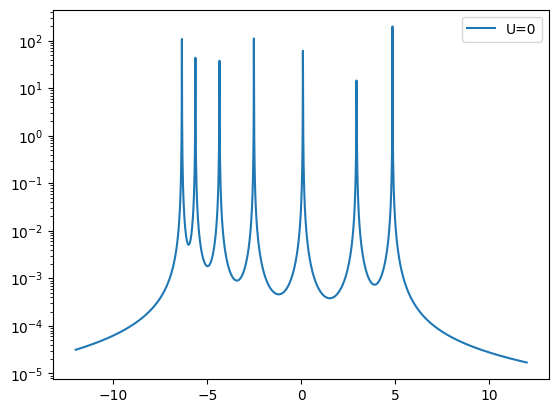

In [58]:
# espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
# screen_espace(espace, egs, beta)
# gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
# DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

plt.plot(energies, DOS0, label="U=0")
# plt.plot(energies, DOS, label="U matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
sigma = Sigma(gf, H_eff, eta=eta)
sig = sigma.retarded(energies)
output_path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/ed')
np.save(output_path/'ed_sigma.npy', sig)
sig = np.load(output_path/'ed_sigma.npy')
sig_trace = np.trace(sig,axis1=1,axis2=2)

In [10]:
ref = np.loadtxt("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/reference/sigma_ed_uii_trace.txt")
ref_energy = ref[:,0]
ref_real = ref[:,1]
ref_imag = ref[:,2]

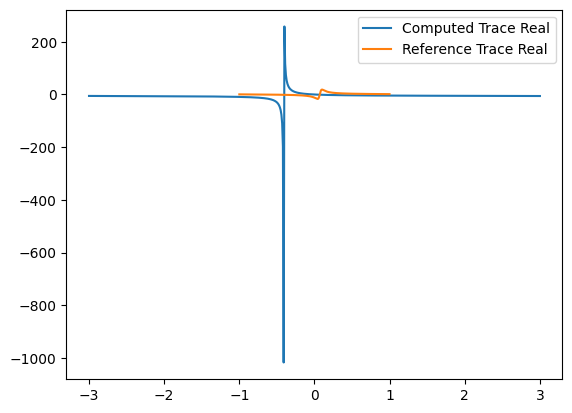

Real part peak positions (computed): [-0.4]
Real part dip positions (computed): [-0.41]


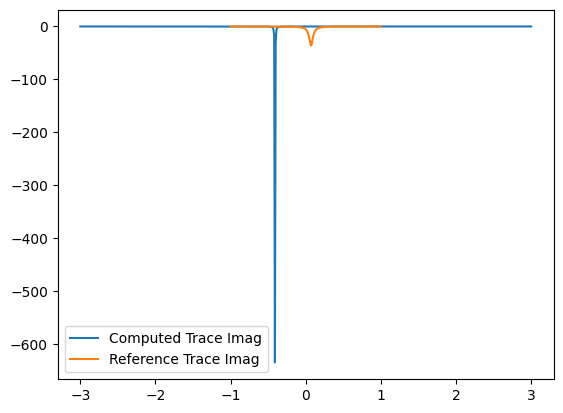

Imaginary part peak positions (computed): [-2.63  2.4 ]
Imaginary part dip positions (computed): [-0.41]


In [11]:
# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_energy, ref_real, label="Reference Trace Real")
# plt.ylim(-10, 10)
# plt.xlim(-1,0.5)
plt.legend()
plt.show()

# Find and print peaks and dips for the real part of the computed trace
real_peaks, _ = find_peaks(sig_trace.real)
real_dips, _ = find_peaks(-sig_trace.real)
real_peak_positions = energies[real_peaks]
real_dip_positions = energies[real_dips]
print("Real part peak positions (computed):", real_peak_positions)
print("Real part dip positions (computed):", real_dip_positions)

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_energy, ref_imag, label="Reference Trace Imag")
# plt.ylim(-10, 10)
plt.legend()
plt.show()

# Find and print peaks and dips for the imaginary part of the computed trace
imag_peaks, _ = find_peaks(sig_trace.imag)
imag_dips, _ = find_peaks(-sig_trace.imag)
imag_peak_positions = energies[imag_peaks]
imag_dip_positions = energies[imag_dips]
print("Imaginary part peak positions (computed):", imag_peak_positions)
print("Imaginary part dip positions (computed):", imag_dip_positions)


In [16]:
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand


class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule_identity, super().retarded(energy), idx_molecule)


def load(filename):
    ed = np.load(filename)
    print(ed.shape)
    return DataSelfEnergy(energies, np.load(filename))

In [17]:
data_folder = "output/lowdin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
nodes = [0, 810, 1116, 1278, 1584, 2394]
imb = 2
S_molecule_identity = np.eye(9)
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule


In [18]:
ed_data_folder = "output/lowdin/ed"
ed_sigma_file = f"{ed_data_folder}/ed_sigma.npy"
ed_sigma = load(ed_sigma_file)


(601, 9, 9)


In [43]:
dmft = load("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/dmft/no_spin/dmft_sigma.npy")

(601, 9, 9)


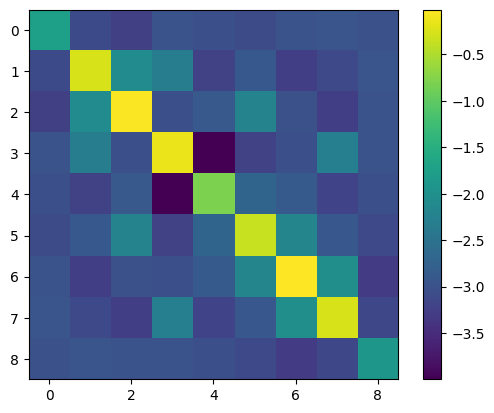

In [50]:
ed = np.load(ed_sigma_file)
plt.imshow(ed.real[0])
plt.colorbar()
plt.show()

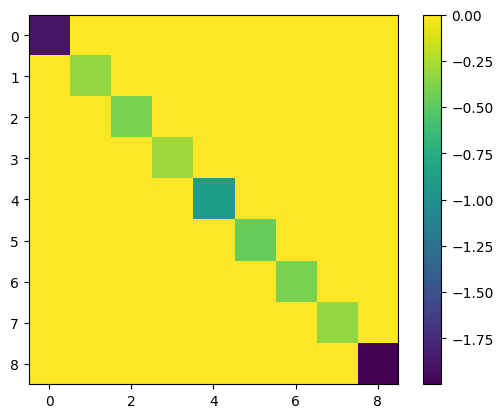

In [49]:
dmft = np.load("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/dmft/no_spin/dmft_sigma.npy")
plt.imshow(dmft.real[100])
plt.colorbar()
plt.show()
